In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import ode
import numpy as np
import itertools
import jax.numpy as jnp
import jax
import diffrax
import optax

In [2]:
# load the network 
c = ode.logicODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "../nn_cno/datasets/working_case_study/MD-test.csv")

WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
c.preprocessing(expansion=False)

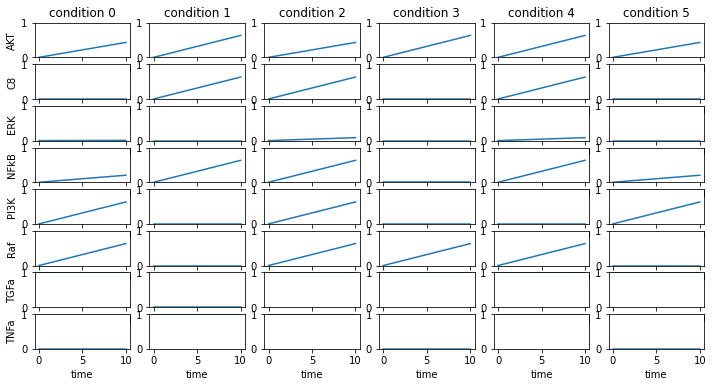

In [4]:
c.plot_simulation(c.simulate(stepsize_controller=diffrax.ConstantStepSize()))

Checking the gradient calculation through the multi-condition setup

In [5]:
pars = c.get_ODEparameters()
jax_pars = jnp.asarray(list(pars.values()))


In [6]:
params = jax_pars.copy()

In [7]:
loss_value, grads = jax.value_and_grad(c.loss_function)(params)

Work on plotting the convergence curves


In [8]:
# install pyPesto for the optimization
# !pip install pyPesto

# Fides implements an Interior Trust Region Reflective for boundary constrained optimization problems based on the papers ColemanLi1994 and ColemanLi1996
# !pip install fides

The first thing we need is to derive an objective function from pyPesto

In [9]:
import pypesto
import fides

Run the fit with ADAMs as reference

In [10]:
c.loss_function(params)
c.fit(params)

step 0, loss: 0.1511961668729782
	params: [1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]
step 10, loss: 0.1170337125658989
	params: [ 1.0930372   2.0984254   0.0677475   1.          2.          0.19703364
  0.88788944  1.887982    0.8915032   1.8949609   0.20725027  1.0765575
  2.0796342   1.0000834   2.          0.08717748  1.          2.
 -0.00253426  1.          2.          0.2032137 ]
step 20, loss: 0.10810359567403793
	params: [1.1308873  2.145422   0.07203323 1.         2.         0.2514174
 0.779795   1.7853216  0.79046917 1.8052882  0.30413726 1.0994068
 2.1037018  1.0005904  2.         0.13200858 1.         2.
 0.02946248 1.         2.         0.28788552]
step 30, loss: 0.10331027954816818
	params: [1.1680802  2.202446   0.06721077 1.         2.         0.28226146
 0.67114204 1.6919429  0.

DeviceArray([1.5101496 , 2.73365   , 0.06890852, 1.        , 2.        ,
             0.3432446 , 0.02082833, 1.2093785 , 0.44593245, 1.6350206 ,
             0.62493426, 0.37679386, 1.3220628 , 1.0039171 , 2.0000012 ,
             0.04037173, 1.        , 2.        , 0.04971356, 1.        ,
             2.        , 0.4724739 ], dtype=float32)

## pyPESTO with Fides and BFGS-hessian

In [11]:
dim_full = len(c.ODEparameters)
lb = c.ODEparameters_lb
ub = c.ODEparameters_ub

# converert the len =1 array to a scalar
def float_obj(x):
    return float(c.loss_function(x))

optimizer = pypesto.optimize.FidesOptimizer(hessian_update =fides.BFGS(),
                                            verbose=False)

objective = pypesto.Objective(fun=float_obj, grad=jax.grad(c.loss_function))

problem = pypesto.Problem(
    objective=objective, lb=lb, ub=ub)

import logging
pypesto.optimize.optimizer.logger.setLevel(logging.WARNING)
result = pypesto.optimize.minimize(problem =problem,
                            optimizer=optimizer,
                            startpoint_method=pypesto.startpoint.latin_hypercube,
                            n_starts=5)

  0%|          | 0/5 [00:00<?, ?it/s]2022-07-20 16:25:45 fides(WARNING) Stopping as gradient norm satisfies absolute convergence criteria: 2.93E-08 < 1.00E-06
WARNING [fides_1:548]:  Stopping as gradient norm satisfies absolute convergence criteria: 2.93E-08 < 1.00E-06
WARNING [fides_1:548]:  Stopping as gradient norm satisfies absolute convergence criteria: 2.93E-08 < 1.00E-06
WARNING [fides_1:548]:  Stopping as gradient norm satisfies absolute convergence criteria: 2.93E-08 < 1.00E-06
 20%|██        | 1/5 [00:00<00:02,  1.45it/s]2022-07-20 16:25:51 fides(WARNING) Stopping as trust region radius 7.91E-17 is smaller than machine precision.
WARNING [fides_2:600]:  Stopping as trust region radius 7.91E-17 is smaller than machine precision.
WARNING [fides_2:600]:  Stopping as trust region radius 7.91E-17 is smaller than machine precision.
WARNING [fides_2:600]:  Stopping as trust region radius 7.91E-17 is smaller than machine precision.
 40%|████      | 2/5 [00:06<00:10,  3.53s/it]2022-07

/Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

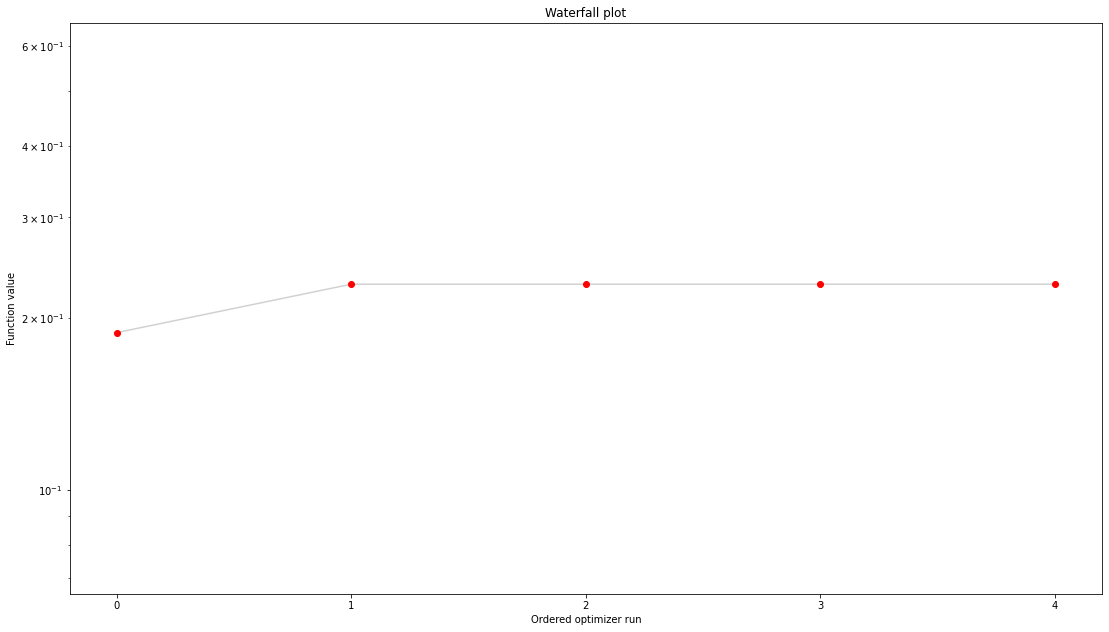

In [12]:
pypesto.visualize.waterfall(result,offset_y=0)


In [13]:
result.optimize_result.as_dataframe()

,id,x,fval,grad,hess,res,sres,n_fval,n_grad,n_hess,n_res,n_sres,x0,fval0,history,exitflag,time,message,optimizer
0,2,"[1.2843756249621237, 4.148127332561438, 3.8298...",0.188496,"[-1.9300854e-08, -6.636213e-09, 2.4180677e-09,...","[[0.9999999998441923, -4.833691869149347e-12, ...",None,None,58,58,0,0,0,"[1.2843758366806652, 4.1481273264270255, 3.829...",8.888605,<pypesto.objective.history.History object at 0...,-5,15.749883,Failed to converge,<FidesOptimizer hessian_update=BFGS verbose=F...
1,1,"[5.755314643737042, 4.473636166881578, 1.29861...",0.229163,"[5.589008e-09, -5.9031436e-07, 2.3587061e-05, ...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None,20,20,0,0,0,"[5.755314643737042, 4.473636166881578, 1.29861...",0.229163,<pypesto.objective.history.History object at 0...,-5,5.524677,Failed to converge,<FidesOptimizer hessian_update=BFGS verbose=F...
2,4,"[7.9963915735166635, 1.5057386293988682, 6.701...",0.229167,"[3.9541193e-10, -2.5053404e-09, 9.440521e-10, ...","[[1.0000000000011444, 8.713510543442149e-11, -...",None,None,15,15,0,0,0,"[7.99639173497986, 1.5057388885062544, 6.70155...",638.649963,<pypesto.objective.history.History object at 0...,3,4.149626,Finished Successfully.,<FidesOptimizer hessian_update=BFGS verbose=F...
3,0,"[9.072352001514083, 1.8182419008326987, 5.7897...",0.229167,"[-8.62421e-10, -2.4331571e-08, 8.94796e-10, 0....","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None,2,2,0,0,0,"[9.072352002376505, 1.818241925164269, 5.78979...",0.229167,<pypesto.objective.history.History object at 0...,3,0.689998,Finished Successfully.,<FidesOptimizer hessian_update=BFGS verbose=F...
4,3,"[3.3299219178742416, 3.0727529659123065, 8.633...",0.229169,"[-2.6224418e-09, -1.7052459e-08, 4.4018705e-10...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None,20,20,0,0,0,"[3.3299219178742416, 3.0727529659123065, 8.633...",0.229169,<pypesto.objective.history.History object at 0...,-5,5.291831,Failed to converge,<FidesOptimizer hessian_update=BFGS verbose=F...


# IPOPT optimization

the installation of `ipopt` returns an error: "SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer."

In [14]:
# ! pip install ipopt

## Next: NLoptOptimizer
Includes a lot of algorithms, see https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms 


In [15]:
! pip install nlopt
! pip install 

ERROR: You must give at least one requirement to install (see "pip help install")


In [16]:
import nlopt
import pypesto
import scipy.optimize

In [17]:
dim_full = len(c.ODEparameters)
lb = c.ODEparameters_lb
ub = c.ODEparameters_ub

# converert the len =1 array to a scalar
def float_obj(x):
    return float(c.loss_function(x))

optimizer = pypesto.optimize.NLoptOptimizer(method=nlopt.LD_LBFGS, local_method= nlopt.G_MLSL_LDS)

objective = pypesto.Objective(fun=float_obj, grad=jax.grad(c.loss_function))

problem = pypesto.Problem(
    objective=objective, lb=lb, ub=ub)

result = pypesto.optimize.minimize(problem =problem,
                            optimizer=optimizer,
                            startpoint_method=pypesto.startpoint.latin_hypercube,
                            n_starts=1)

ValueError: Method "11" does not allow a local method. Please set `local_method` to None.

In [ ]:
nlopt is None

False